In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
from collections import deque
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pickle


In [10]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [6]:

# Define the Deep Q-Network (DQN) model
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size2//2)
        self.fc4 = nn.Linear(hidden_size2//2, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Define the Deep Q-Learning Agent
class DQNAgent:
    def __init__(self, state_size, action_size, hidden_size1, hidden_size2, learning_rate, gamma, epsilon_start, epsilon_end, epsilon_decay):
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.model = DQN(state_size, hidden_size1, hidden_size2, action_size).to(device)
        self.target_model = DQN(state_size, hidden_size1, hidden_size2, action_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.memory = deque(maxlen=10000)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state.flatten()).unsqueeze(0).to(device)
        q_values = self.model(state)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in batch:
            state = torch.FloatTensor(state.flatten()).unsqueeze(0).to(device)
            next_state = torch.FloatTensor(next_state.flatten()).unsqueeze(0).to(device)
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.target_model(next_state).detach())
            target_f = self.model(state).squeeze(0)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state).squeeze(0), target_f)
            loss.backward()
            self.optimizer.step()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_end:
            self.epsilon *= self.epsilon_decay

In [7]:
# Define the environment class
class StockMarketEnvironment:
    def __init__(self, data, window_size):

        # Removing Date and Time because the data is already continuous format
        X = data.drop(['datetime','signal'], axis=1)

        self.data = X
        self.window_size = window_size
        self.current_step = window_size
        self.scaler = StandardScaler()
        self.data_normalized = self.scaler.fit_transform(X.values)
        self.data_length = len(X)

    def reset(self):
        self.current_step = self.window_size
        return self.data_normalized[0:self.window_size]

    def step(self, action):
        reward = get_reward(action, self.data_normalized[self.current_step][3], self.data_normalized[self.current_step][0])
        next_step = self.current_step + 1
        done = next_step >= self.data_length
        next_state = self.data_normalized[next_step - self.window_size:next_step]
        self.current_step = next_step
        return next_state, reward, done, {}


In [8]:
# Load trained agents from a pickle file
with open('trained_agents.pkl', 'rb') as f:
    agents = pickle.load(f)

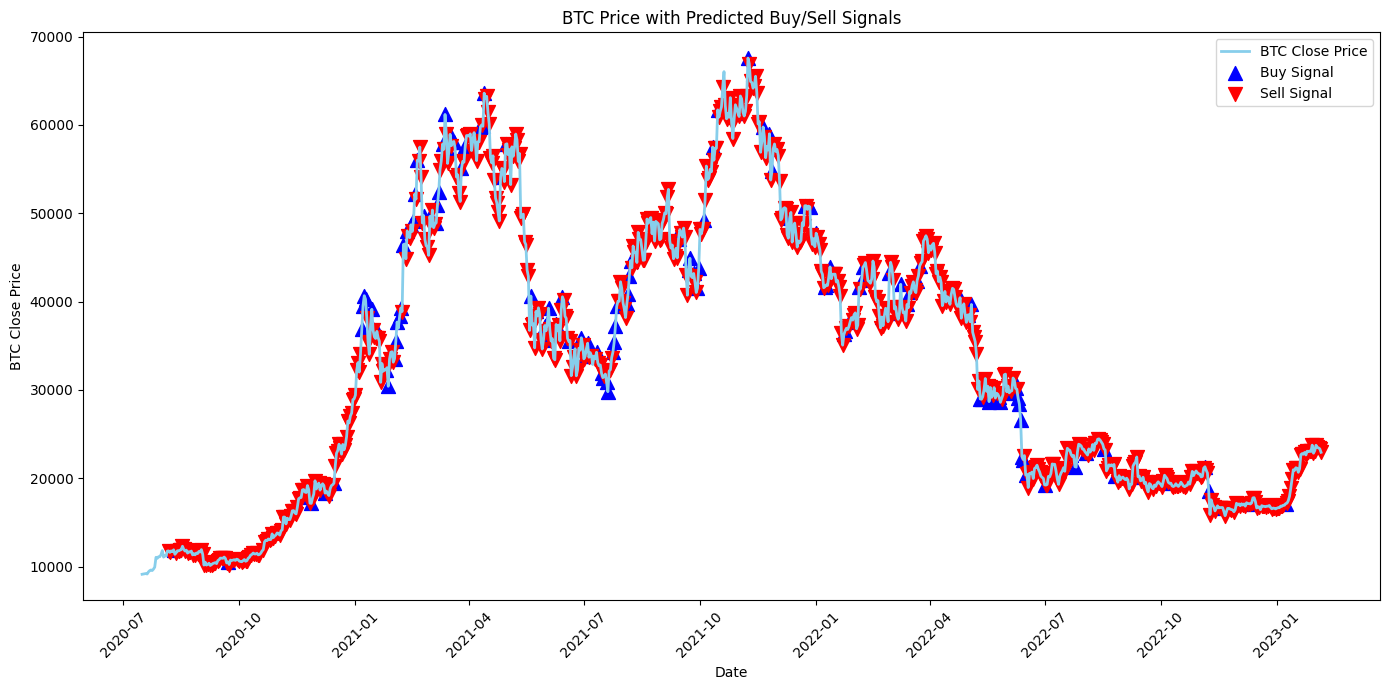

In [11]:

df = pd.read_csv('./DATA/data.csv')
window_size = 20 # No. of days
env = StockMarketEnvironment(df, window_size)


# Function to apply prediction to each row
def predict_signal_for_row(df, index, agents):
    if index < window_size:
        return 1
    last_window_rows = df[index - window_size:index]
    predictions = [agent.act(last_window_rows) for agent in agents]
    # Assuming a simple voting scheme where the majority vote determines the signal
    return max(set(predictions), key=predictions.count)

data_normalized=env.data_normalized

df['predicted_signal'] = [predict_signal_for_row(data_normalized, i, agents) for i in range(len(data_normalized))]

# Ensure datetime is in the correct format
datetime = pd.to_datetime(df['datetime'])



plt.figure(figsize=(14, 7))
plt.plot(datetime, df['close'], label='BTC Close Price', color='skyblue', linewidth=2)

df = df.drop(['datetime','signal'], axis=1)

df['datetime']=datetime
# Adjust the conditions to match the labels
# Highlight buy signals
buy_signals = df[df['predicted_signal'] == 2]  # Assuming 0 represents 'buy'
plt.scatter(buy_signals['datetime'], buy_signals['close'], label='Buy Signal', marker='^', color='blue', alpha=1, s=100)

# Highlight sell signals
sell_signals = df[df['predicted_signal'] == 0]  # Assuming 1 represents 'sell'
plt.scatter(sell_signals['datetime'], sell_signals['close'], label='Sell Signal', marker='v', color='red', alpha=1, s=100)

plt.title('BTC Price with Predicted Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('BTC Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("NicePlot")
plt.show()
